# QSMxT

**Author:** Ashley Stewart

**Date:** 25 Aug 2025

### Citation and Resources:
#### Tools included in this workflow

- QSMxT: Stewart AW, Robinson SD, O'Brien K, et al. QSMxT: Robust masking and artifact reduction for quantitative susceptibility mapping. Magnetic Resonance in Medicine. 2022;87(3):1289-1300. [doi:10.1002/mrm.29048](https://doi.org/10.1002/mrm.29048)

- QSMxT: Stewart AW, Bollman S, et al. QSMxT/QSMxT. GitHub; 2022[. https://github.com/QSMxT/QSM](https://github.com/QSMxT/QSMxT)

#### Dataset
- Bollmann, S., & Stewart, A. (2023, August 7). QSM DICOM testdata for QSMxT pipeline. Retrieved from [osf.io/ru43c](https://osf.io/ru43c)

# QSMxT Interactive Notebook

This interactive notebook estimates Quantitative Susceptibility Maps (QSMs) for two gradient-echo (GRE) MRI acquisitions using [QSMxT](https://github.com/QSMxT/QSMxT) provided by the [Neurodesk](https://neurodesk.org) project.

## What is QSM?

QSM is a form of quantitative MRI (qMRI) that estimates the magnetic susceptibility distribution across an imaged object. Magnetic susceptibility is the degree to which a material becomes magnetised by an external magnetic field. Major contributors to susceptibility include iron, calcium, and myelin, with the susceptibility of water typically approximating a zero-reference, though it is slightly diamagnetic. Read more about QSM [here](https://doi.org/10.1002/mrm.25358).

## What is QSMxT?

[QSMxT](https://qsmxt.github.io) is a suite of tools for building and running automated pipelines for QSM that:

- is available open-source without any licensing required;
- is distributed as a software container making it straightforward to access and install (Neurodesk!)
- scales its processing to execute across many acquisitions through jobs parallelisation (using multiple processors or HPCs) provided by [Nipype](https://nipype.readthedocs.io);
- automates steps that usually require manual intervention and scripting, including:
  - DICOM to [BIDS](https://bids-specification.readthedocs.io/en/stable/index.html) conversion;
  - QSM reconstruction using a range of algorithms;
  - segmentation using [FastSurfer](https://github.com/Deep-MI/FastSurfer);
  - group space generation using [ANTs](https://github.com/ANTsX/ANTs);
  - export of susceptibility statistics by subject and region of interest (ROI) to CSV.

![image.png](../images/image.png)

## How do I access QSMxT?

There are a few ways you can access QSMxT:

 - **This notebook**: You can access QSMxT in this notebook right now!
   - If you are running this on a Neurodesk Play instance, you can upload your own data into the sidebar via drag-and-drop.
 - **Neurodesktop**: QSMxT is in the applications menu of Neurodesktop.
   - On Neurodesk Play, upload your own data into the desktop via drag-and-drop.
   - On a local install of Neurodesk, bring any necessary files into the shared `~/neurodesktop-storage` directory
 - **Local install**: QSMxT can also be installed via the [Docker container](https://qsmxt.github.io/QSMxT/installation)
 - **HPC install**: QSMxT can also be installed via the [Singularity container](https://qsmxt.github.io/QSMxT/installation) for use on HPCs

# Download example DICOMs

Here, we download some example DICOMs from our OSF repository for QSMxT.

These data include GRE and T1-weighted acquisitions for one subject (duplicated to act as two subjects).

In [1]:
!osf -p ru43c clone . > /dev/null 2>&1
!tar xf osfstorage/dicoms-unsorted.tar
!rm -rf osfstorage/
!tree dicoms-unsorted | head
!echo -e "...\nThere are `ls dicoms-unsorted | wc -l` unsorted DICOMs in ./dicoms-unsorted/"

dicoms-unsorted
├── MR.1.1.dcm
├── MR.1.10.dcm
├── MR.1.100.dcm
├── MR.1.101.dcm
├── MR.1.102.dcm
├── MR.1.103.dcm
├── MR.1.104.dcm
├── MR.1.105.dcm
├── MR.1.106.dcm
...
There are 1216 unsorted DICOMs in ./dicoms-unsorted/


# Load QSMxT

To load QSMxT inside a notebook, we can use the available module system:

In [3]:
import module
await module.load('qsmxt/8.1.1')
!qsmxt --version

[INFO]: QSMxT v8.1.1


# Data standardisation

QSMxT requires input data to conform to the [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/).

Luckily, QSMxT also provides scripts that can convert unorganised NIfTI or DICOM images to BIDS. If you are using NIfTI images and do not have DICOMs, see [nifti-convert](https://qsmxt.github.io/QSMxT/using-qsmxt/data-preparation#nifti-to-bids).

## Convert DICOM to BIDS

The DICOM to BIDS conversion must identify which series should be used for QSM reconstruction (e.g. MEGRE), and which series should be used for segmentation (T1-weighted). Because this information is not stored in the DICOM header in a standardised way, it can only be estimated based on other fields, or the user must identify series themselves.

If QSMxT is run interactively, the user will be prompted to identify the relevant series. However, because we are running QSMxT in a notebook, we disable the interactivity using `--auto_yes` and allow QSMxT to guess the intended purpose of each acquisition. In this case, it makes the right guess:

In [5]:
!dicom-convert dicoms-unsorted bids --auto_yes

/opt/miniconda-4.12.0/lib/python3.8/site-packages/dicompare/io.py:30: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  from nibabel.nicom.csareader import get_csa_header
[INFO]: Running QSMxT 8.1.1
[INFO]: Command: /opt/miniconda-4.12.0/bin/dicom-convert dicoms-unsorted bids --auto_yes
[INFO]: Python interpreter: /opt/miniconda-4.12.0/bin/python3.8
Loading DICOM files: 100%|█████████████████| 1216/1216 [00:11<00:00, 102.57it/s]
[INFO]: Loaded DICOM session in 12.07 seconds
/opt/miniconda-4.12.0/lib/python3.8/site-packages/dicompare/acquisition.py:144: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  session_df["B

In [6]:
!tree bids

bids
├── log_2025-10-30_01-40-18013068.txt
├── references.txt
├── sub-1
│   └── ses-20170705
│       └── anat
│           ├── sub-1_ses-20170705_acq-acqmp2ragehighres0p5isoslab_part-mag_T1w.json
│           ├── sub-1_ses-20170705_acq-acqmp2ragehighres0p5isoslab_part-mag_T1w.nii
│           ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_part-mag_T2starw.json
│           ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_part-mag_T2starw.nii
│           ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_part-phase_T2starw.json
│           └── sub-1_ses-20170705_acq-acqqsmp21mmisote20_part-phase_T2starw.nii
└── sub-2
    └── ses-20170705
        └── anat
            ├── sub-2_ses-20170705_acq-acqmp2ragehighres0p5isoslab_part-mag_T1w.json
            ├── sub-2_ses-20170705_acq-acqmp2ragehighres0p5isoslab_part-mag_T1w.nii
            ├── sub-2_ses-20170705_acq-acqqsmp21mmisote20_part-mag_T2starw.json
            ├── sub-2_ses-20170705_acq-acqqsmp21mmisote20_part-mag_T2starw.nii
            ├── sub-2_s

# Inspect input data

Here we define a function we will use to visualise NIfTI images so we can view some of the input data:

In [7]:
%%capture
!pip install seaborn numpy nibabel pandas

In [8]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib

def show_nii(nii_path, title=None, figsize=(4,5), cmap='gray', **imshow_args):
    # load data\n",
    data_1 = nib.load(nii_path).get_fdata()

    # get middle slices\n",
    slc_data1 = np.rot90(data_1[np.shape(data_1)[0]//2,:,:])
    slc_data2 = np.rot90(data_1[:,np.shape(data_1)[1]//2,:])
    slc_data3 = np.rot90(data_1[:,:,np.shape(data_1)[2]//2])

    # show slices\n",
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    if title: plt.suptitle(title)

    axes[0].imshow(slc_data1, cmap=cmap, **imshow_args)
    axes[1].imshow(slc_data2, cmap=cmap, **imshow_args)
    axes[2].imshow(slc_data3, cmap=cmap, **imshow_args)

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

    fig.tight_layout()
    fig.subplots_adjust(top=1.55)
    plt.show()

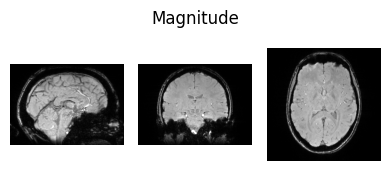

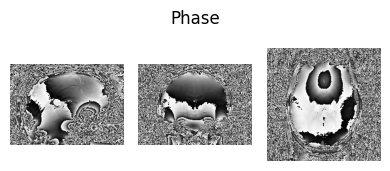

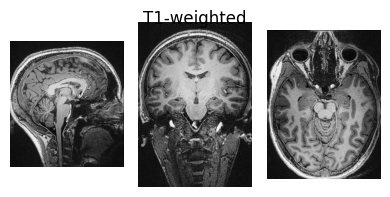

In [9]:
show_nii(glob("bids/sub-*/ses-*/anat/*mag*T2starw*nii*")[0], title="Magnitude", vmax=500)
show_nii(glob("bids/sub-*/ses-*/anat/*phase*T2starw*nii*")[0], title="Phase")
show_nii(glob("bids/sub-*/ses-*/anat/*T1w*nii*")[0], title="T1-weighted")

##### Interactive Display using Niivue
Uncomment the next cell if you want to inspect the T1-weighted image interactively

In [13]:
# from ipyniivue import NiiVue

# nv_T1 = NiiVue()
# nv_T1.load_volumes([{"path": glob("bids/sub-*/ses-*/anat/*T1w*nii*")[0]}])
# nv_T1

# Run QSMxT

We are now ready to run QSMxT! We will generate susceptibility maps and segmentations, and export analysis CSVs to file.

The usual way of running QSMxT is to use `qsmxt bids_dir`. This will launch an interactive command-line interface (CLI) to setup your desired pipelines. However, since we are running this in a notebook, we need to use command-line arguments to by-pass the interface and execute a pipeline.

But first, let's consider our pipeline settings. For QSM reconstruction, QSMxT provides a range of sensible defaults fit for different purposes. We can list the premade QSM pipelines using `--list_premades`. For the full pipeline details used for each premade pipeline, see [qsm_pipelines.json](https://github.com/QSMxT/QSMxT/blob/main/qsmxt/qsm_pipelines.json).

In [14]:
!qsmxt --list_premades

=== Premade pipelines ===
default: Default QSMxT settings (GRE; assumes human brain)
gre: Applies suggested settings for 3D-GRE images
epi: Applies suggested settings for 3D-EPI images (assumes human brain)
bet: Applies a traditional BET-masking approach (artefact reduction unavailable; assumes human brain)
fast: Applies a set of fast algorithms
body: Applies suggested settings for non-brain applications
nextqsm: Applies suggested settings for running the NeXtQSM algorithm (assumes human brain)
[INFO]: Finished


For this demonstration, we will go with the `fast` pipeline. To export segmentations and analysis results, we will use `--do_segmentation` and `--do_analysis`. The `--auto_yes` option avoid the interactive CLI interface that cannot be used in a notebook:

In [15]:
!qsmxt bids \
    --premade fast \
    --do_qsm \
    --do_segmentation \
    --do_analysis \
    --auto_yes

[INFO]: QSMxT v8.1.1
[INFO]: Python interpreter: /opt/miniconda-4.12.0/bin/python3.8
[INFO]: Command: qsmxt /home/jovyan/Git_repositories/example-notebooks/books/structural_imaging/bids --premade 'fast' --do_qsm --do_segmentation --do_analysis --auto_yes
[WARNING]: Pipeline is NOT guidelines compliant (see https://doi.org/10.1002/mrm.30006):; Phase-quality-based masking recommended
[INFO]: Available memory: 195.188 GB
[INFO]: Creating QSMxT workflow for sub-1.ses-20170705.acq-acqmp2ragehighres0p5isoslab.T1w...
[INFO]: Creating QSMxT workflow for sub-1.ses-20170705.acq-acqqsmp21mmisote20.T2starw...
[INFO]: Creating QSMxT workflow for sub-2.ses-20170705.acq-acqmp2ragehighres0p5isoslab.T1w...
[INFO]: Creating QSMxT workflow for sub-2.ses-20170705.acq-acqqsmp21mmisote20.T2starw...
[INFO]: Running using MultiProc plugin with n_procs=32
251030-02:01:26,143 nipype.workflow INFO:
	 Workflow qsmxt-workflow settings: ['check', 'execution', 'logging', 'monitoring']
251030-02:01:26,393 nipype.work

# View results

Let's have a look at the generated `qsm` folder:

In [16]:
!tree bids/derivatives/qsmxt-*-* --dirsfirst

bids/derivatives/qsmxt-2025-10-30-020038
├── sub-1
│   └── ses-20170705
│       ├── anat
│       │   ├── sub-1_ses-20170705_acq-acqmp2ragehighres0p5isoslab_T1w_space-orig_dseg.nii
│       │   ├── sub-1_ses-20170705_acq-acqmp2ragehighres0p5isoslab_T1w_space-qsm_dseg.nii
│       │   ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_Chimap.json
│       │   ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_Chimap.nii
│       │   ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_space-orig_dseg.nii
│       │   └── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_space-qsm_dseg.nii
│       └── extra_data
│           ├── sub-1_ses-20170705_acq-acqmp2ragehighres0p5isoslab_T1w_desc-t1w-to-qsm_transform.mat
│           ├── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_desc-t1w-to-qsm_transform.mat
│           └── sub-1_ses-20170705_acq-acqqsmp21mmisote20_T2starw_qsm-analysis.csv
├── sub-2
│   └── ses-20170705
│       ├── anat
│       │   ├── sub-2_ses-20170705_acq-acqmp2ragehigh

The `references.txt` file contains a list of all the algorithms used and relevant citations:

In [17]:
!cat bids/derivatives/qsmxt-*-*/references.txt

== References ==

 - QSMxT: Stewart AW, Robinson SD, O'Brien K, et al. QSMxT: Robust masking and artifact reduction for quantitative susceptibility mapping. Magnetic Resonance in Medicine. 2022;87(3):1289-1300. doi:10.1002/mrm.29048

 - QSMxT: Stewart AW, Bollman S, et al. QSMxT/QSMxT. GitHub; 2022. https://github.com/QSMxT/QSMxT

 - Python package - Nipype: Gorgolewski K, Burns C, Madison C, et al. Nipype: A Flexible, Lightweight and Extensible Neuroimaging Data Processing Framework in Python. Frontiers in Neuroinformatics. 2011;5. Accessed April 20, 2022. doi:10.3389/fninf.2011.00013

 - Brain extraction: Smith SM. Fast robust automated brain extraction. Human Brain Mapping. 2002;17(3):143-155. doi:10.1002/hbm.10062

 - Brain extraction: Liangfu Chen. liangfu/bet2 - Standalone Brain Extraction Tool. GitHub; 2015. https://github.com/liangfu/bet2

 - Unwrapping algorithm - ROMEO: Dymerska B, Eckstein K, Bachrata B, et al. Phase unwrapping with a rapid opensource minimum spanning tree a

Let's view one of the QSM results:

## QSM results

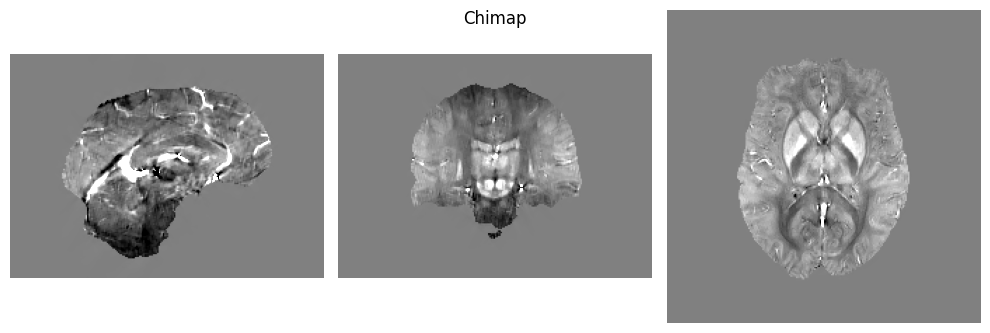

In [18]:
show_nii(glob("bids/derivatives/qsmxt-*/sub-*/ses-*/anat/*Chimap.nii*")[0], title="Chimap", figsize=(10,8), cmap='gray', vmin=-0.1, vmax=0.1)

## Segmentations

Segmentations are generated in both the QSM space and the T1-weighted space. Transformations are also made available.

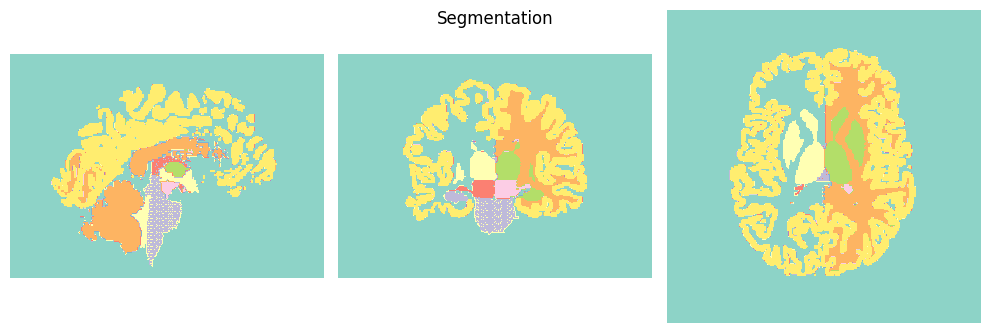

In [19]:
show_nii(glob("bids/derivatives/qsmxt-*/sub-*/ses-*/anat/*qsm_dseg.nii*")[0], title="Segmentation", figsize=(10,8), cmap='Set3', vmin=0, vmax=96)

## Analysis CSVs

CSV files have been exported containing susceptibility values in regions of interest for each subject.

Here we will load the CSVs, inspect the data and generate figures:

In [20]:
# import modules
import pandas as pd
import seaborn as sns

The raw CSV files use names from FreeSurfer as exported by FastSurfer. The full list of regions is available [here](https://github.com/QSMxT/QSMxT/blob/main/qsmxt/aseg_labels.csv).

In [21]:
pd.read_csv(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/extra*/*.csv")[0])

,roi,num_voxels,min,max,median,mean,std
0,3rd-Ventricle,587,-0.234321,0.054945,-0.018367,-0.021842,0.033371
1,4th-Ventricle,1544,-0.126117,0.052944,-0.044766,-0.045198,0.030768
2,Brain-Stem,18687,-0.750579,0.184913,-0.045976,-0.042085,0.029045
3,CSF,834,-1.393693,0.945752,0.030098,0.033957,0.140176
4,Left-Accumbens-area,524,-0.141920,0.128334,0.025588,0.022306,0.031363
...,...,...,...,...,...,...,...
91,ctx-rh-superiorfrontal,29626,-0.133274,0.251870,-0.003875,-0.009282,0.024289
92,ctx-rh-superiorparietal,12072,-0.084225,0.306628,-0.015670,-0.014582,0.022277
93,ctx-rh-superiortemporal,16251,-0.090982,0.248737,0.006754,0.012995,0.024299
94,ctx-rh-supramarginal,11992,-0.056940,0.239688,0.019331,0.019976,0.022774


We will select a subset of these ROIs and give them more readable names:

In [22]:
# define regions of interest
# see https://github.com/QSMxT/QSMxT/blob/main/qsmxt/aseg_labels.csv for a full list
rois = { 
    "Thalamus" : [9, 10, 48, 49],
    "Pallidum" : [12, 13, 52, 53],
    "Caudate" : [11, 50],
    "Putamen" : [12, 51],
    "Brain stem" : [16],
    "CSF" : [24, 122, 257, 701],
    "White matter" : [2, 7, 41, 46, 177]
}
roi_names = { value: key for key in rois for value in rois[key] }
roi_ids = [value for roi in rois.values() for value in roi]

In [23]:
# load a reconstruction
qsm = nib.load(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/anat*/*Chimap.nii*")[0]).get_fdata().flatten()
seg = nib.load(glob("bids/derivatives/qsmxt-*-*/sub*/ses*/anat*/*space-qsm*dseg.nii*")[0]).get_fdata().flatten()

In [24]:
# retain only the rois
qsm = qsm[np.isin(seg, roi_ids)]
seg = seg[np.isin(seg, roi_ids)]

In [25]:
# convert to a dataframe for plotting purposes
seg = pd.Series(seg).map(roi_names)
data = pd.DataFrame({ 'qsm' : qsm, 'seg' : seg })

In [26]:
# summarise data by region including the average and standard deviation
data.groupby('seg')['qsm'].agg(['mean', 'std']).sort_values('mean').round(decimals=3)

,mean,std
seg,,
Brain stem,-0.042,0.029
White matter,-0.002,0.027
Thalamus,0.030,0.034
CSF,0.034,0.140
Pallidum,0.034,0.060
Putamen,0.047,0.033
Caudate,0.048,0.023


In [27]:
medians = data.groupby('seg')['qsm'].median().sort_values()
order = medians.index

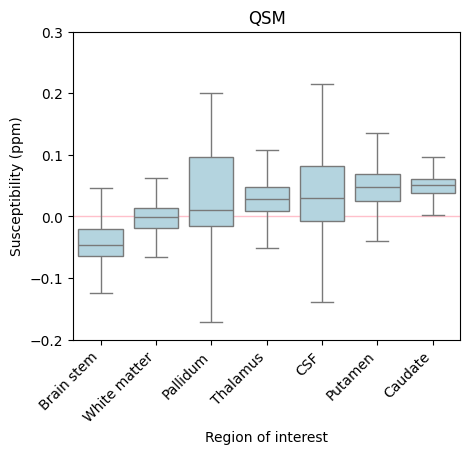

In [28]:
# plot
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=data, y='qsm', x='seg', fliersize=0, color='lightblue', order=order, ax=ax)
ax.set_xticks(range(len(ax.get_xticks())))  # Set tick positions explicitly
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.set_ylim(-0.2, 0.3)
ax.axhline(y=0, color='pink', linestyle='-', linewidth=1, zorder=-1)
ax.set_xlabel("Region of interest")
ax.set_ylabel("Susceptibility (ppm)")
ax.set_title("QSM")
plt.show()

#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [29]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-10-30T02:24:57.856137+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

nibabel   : 5.2.1
numpy     : 2.2.6
pandas    : 2.3.3
seaborn   : 0.13.2
matplotlib: 3.8.4
ipyniivue : 2.3.2

